In [1]:
import os
import tensorflow as tf


os.environ["CUDA_VISIBLE_DEVICES"] = "3" 


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
       
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU')
    except RuntimeError as e:
       
        print(e)
else:
    print("No GPUs found. Check your device installation.")

1 Physical GPUs, 1 Logical GPU


## Libraries

In [2]:
import numpy as np
import pandas as pd
import os.path
import scipy.misc 
from scipy import io
import scipy.io as sio
import tensorflow as tf
from numpy import array
from numpy import argmax
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Embedding, GlobalAveragePooling1D
from tensorflow.keras.constraints import max_norm
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Activation, SpatialDropout1D, GlobalMaxPooling1D, TimeDistributed, UpSampling2D
from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam


## Loading Data / Reshaping

In [3]:
def load_data_test(file_names):
    all_data = []
    all_labels = []
    for f in file_names:
        mat_contents = scipy.io.loadmat(f)
        data = mat_contents['X_3D']
        labels = mat_contents['categoryLabels'].flatten()

        #  only 5184  are taken
        min_trials = 5184
        all_data.append(data[:, :, :min_trials])
        all_labels.append(labels[:min_trials])

    return np.array(all_data), np.array(all_labels)



def subject_data(file_name):
    # Reshaping
    all_data, all_label = load_data_test([file_name])
    all_data_st = np.swapaxes(all_data, 0, 3)
    all_data_st = np.swapaxes(all_data_st, 2, 3)

    
    all_labels_st = np.swapaxes(all_label, 0, 1)

    # Label Array Editing
    all_labels_ext = []
    for i in range(len(all_labels_st)):
        all_labels_ext.append(all_labels_st[i][0])

    all_labels_ext = np.array(all_labels_ext)

    # Train test Spliting
    from sklearn.model_selection import train_test_split
    x_all_4_train, x_all_4_test, y_all_4_train, y_all_4_test = train_test_split(all_data_st, all_labels_ext, test_size=0.2)
    
    return x_all_4_train, x_all_4_test, y_all_4_train, y_all_4_test
    

## CNN Model

In [4]:

model = Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=(124,1,32)))
model.add(tf.keras.layers.Conv2D(filters=400, kernel_size=(7,1), padding='same', use_bias=False, kernel_constraint=max_norm(0.3)))
model.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(30,1), padding='same', use_bias=False, kernel_constraint=max_norm(0.4)))
model.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,1)))
model.add(tf.keras.layers.Activation("elu"))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(15,1), padding='same', use_bias=False, kernel_constraint=max_norm(0.5)))
model.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(7,1), padding='same', use_bias=False, kernel_constraint=max_norm(0.5)))
model.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(tf.keras.layers.Activation("elu"))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=80, kernel_size=(5,1), padding='same', use_bias=False, kernel_constraint=max_norm(0.5)))
model.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,1), padding='same', use_bias=False, kernel_constraint=max_norm(0.5)))
model.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(tf.keras.layers.Activation("elu"))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', use_bias=False, depthwise_constraint=max_norm(0.4), pointwise_constraint=max_norm(0.6)))  # Corrected this line
model.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(tf.keras.layers.Activation("elu"))
model.add(tf.keras.layers.Dropout(0.6))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(7, use_bias=False, kernel_constraint=max_norm(0.6)))
model.add(tf.keras.layers.Activation("softmax"))


## Train Model

Training for subject S1.mat
Epoch 1/100


2024-09-13 14:10:46.749740: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


519/519 [==============================] - 18s 21ms/step - loss: 1.8639 - sparse_categorical_accuracy: 0.2423 - val_loss: 1.5943 - val_sparse_categorical_accuracy: 0.3500
Epoch 2/100
519/519 [==============================] - 10s 19ms/step - loss: 1.6854 - sparse_categorical_accuracy: 0.3130 - val_loss: 1.5479 - val_sparse_categorical_accuracy: 0.3751
Epoch 3/100
519/519 [==============================] - 10s 19ms/step - loss: 1.5862 - sparse_categorical_accuracy: 0.3632 - val_loss: 1.4633 - val_sparse_categorical_accuracy: 0.4166
Epoch 4/100
519/519 [==============================] - 10s 19ms/step - loss: 1.4967 - sparse_categorical_accuracy: 0.4029 - val_loss: 1.4235 - val_sparse_categorical_accuracy: 0.4503
Epoch 5/100
519/519 [==============================] - 10s 19ms/step - loss: 1.4444 - sparse_categorical_accuracy: 0.4340 - val_loss: 1.4410 - val_sparse_categorical_accuracy: 0.4156
Epoch 6/100
519/519 [==============================] - 10s 19ms/step - loss: 1.4063 - sparse_cate

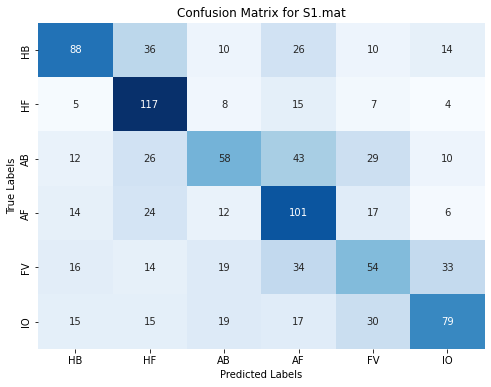

Training for subject S2.mat
Epoch 1/100


2024-09-13 14:16:41.411454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


519/519 [==============================] - 10s 18ms/step - loss: 1.7946 - sparse_categorical_accuracy: 0.3038 - val_loss: 1.5194 - val_sparse_categorical_accuracy: 0.3934
Epoch 2/100
519/519 [==============================] - 9s 17ms/step - loss: 1.5357 - sparse_categorical_accuracy: 0.3923 - val_loss: 1.4777 - val_sparse_categorical_accuracy: 0.4118
Epoch 3/100
519/519 [==============================] - 9s 17ms/step - loss: 1.4477 - sparse_categorical_accuracy: 0.4254 - val_loss: 1.4655 - val_sparse_categorical_accuracy: 0.4397
Epoch 4/100
519/519 [==============================] - 9s 17ms/step - loss: 1.4112 - sparse_categorical_accuracy: 0.4271 - val_loss: 1.4623 - val_sparse_categorical_accuracy: 0.4195
Epoch 5/100
519/519 [==============================] - 9s 17ms/step - loss: 1.3606 - sparse_categorical_accuracy: 0.4562 - val_loss: 1.4599 - val_sparse_categorical_accuracy: 0.4474
Epoch 6/100
519/519 [==============================] - 9s 17ms/step - loss: 1.3311 - sparse_categoric

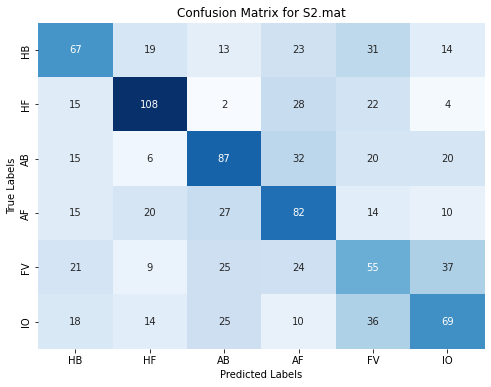

Training for subject S3.mat
Epoch 1/100


2024-09-13 14:22:29.852960: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


519/519 [==============================] - 11s 18ms/step - loss: 1.7506 - sparse_categorical_accuracy: 0.3419 - val_loss: 1.4020 - val_sparse_categorical_accuracy: 0.4744
Epoch 2/100
519/519 [==============================] - 9s 18ms/step - loss: 1.4622 - sparse_categorical_accuracy: 0.4237 - val_loss: 1.3561 - val_sparse_categorical_accuracy: 0.4879
Epoch 3/100
519/519 [==============================] - 9s 17ms/step - loss: 1.3719 - sparse_categorical_accuracy: 0.4659 - val_loss: 1.3485 - val_sparse_categorical_accuracy: 0.4725
Epoch 4/100
519/519 [==============================] - 9s 17ms/step - loss: 1.2967 - sparse_categorical_accuracy: 0.4912 - val_loss: 1.3324 - val_sparse_categorical_accuracy: 0.4860
Epoch 5/100
519/519 [==============================] - 9s 17ms/step - loss: 1.2336 - sparse_categorical_accuracy: 0.5216 - val_loss: 1.3204 - val_sparse_categorical_accuracy: 0.4928
Epoch 6/100
519/519 [==============================] - 9s 18ms/step - loss: 1.2030 - sparse_categoric

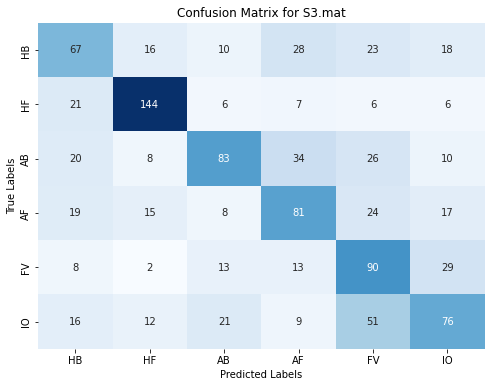

Training for subject S4.mat
Epoch 1/100


2024-09-13 14:28:26.001042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


519/519 [==============================] - 11s 18ms/step - loss: 1.8452 - sparse_categorical_accuracy: 0.3210 - val_loss: 1.5513 - val_sparse_categorical_accuracy: 0.3809
Epoch 2/100
519/519 [==============================] - 9s 17ms/step - loss: 1.5250 - sparse_categorical_accuracy: 0.4025 - val_loss: 1.4821 - val_sparse_categorical_accuracy: 0.4050
Epoch 3/100
519/519 [==============================] - 9s 17ms/step - loss: 1.4292 - sparse_categorical_accuracy: 0.4437 - val_loss: 1.5112 - val_sparse_categorical_accuracy: 0.3963
Epoch 4/100
519/519 [==============================] - 9s 17ms/step - loss: 1.3733 - sparse_categorical_accuracy: 0.4558 - val_loss: 1.4809 - val_sparse_categorical_accuracy: 0.4137
Epoch 5/100
519/519 [==============================] - 9s 18ms/step - loss: 1.3468 - sparse_categorical_accuracy: 0.4750 - val_loss: 1.4531 - val_sparse_categorical_accuracy: 0.4224
Epoch 6/100
519/519 [==============================] - 9s 17ms/step - loss: 1.3191 - sparse_categoric

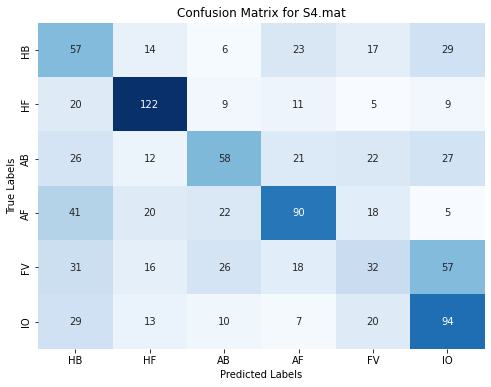

Training for subject S5.mat
Epoch 1/100


2024-09-13 14:32:35.069407: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


519/519 [==============================] - 11s 18ms/step - loss: 1.5865 - sparse_categorical_accuracy: 0.3834 - val_loss: 1.3375 - val_sparse_categorical_accuracy: 0.4735
Epoch 2/100
519/519 [==============================] - 9s 17ms/step - loss: 1.3104 - sparse_categorical_accuracy: 0.4832 - val_loss: 1.2291 - val_sparse_categorical_accuracy: 0.5256
Epoch 3/100
519/519 [==============================] - 9s 17ms/step - loss: 1.2049 - sparse_categorical_accuracy: 0.5317 - val_loss: 1.2234 - val_sparse_categorical_accuracy: 0.5352
Epoch 4/100
519/519 [==============================] - 9s 18ms/step - loss: 1.1225 - sparse_categorical_accuracy: 0.5703 - val_loss: 1.1786 - val_sparse_categorical_accuracy: 0.5391
Epoch 5/100
519/519 [==============================] - 9s 17ms/step - loss: 1.0732 - sparse_categorical_accuracy: 0.5925 - val_loss: 1.1506 - val_sparse_categorical_accuracy: 0.5564
Epoch 6/100
519/519 [==============================] - 9s 17ms/step - loss: 1.0292 - sparse_categoric

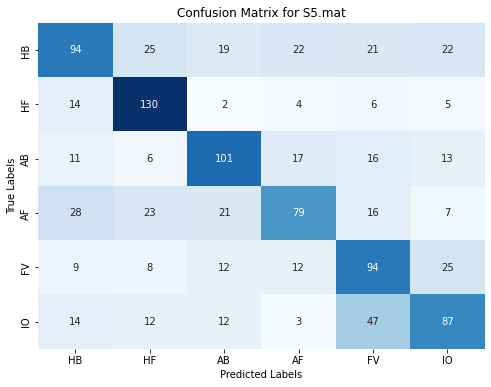

Training for subject S6.mat
Epoch 1/100


2024-09-13 14:37:52.518649: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


519/519 [==============================] - 11s 18ms/step - loss: 1.5692 - sparse_categorical_accuracy: 0.4109 - val_loss: 1.3074 - val_sparse_categorical_accuracy: 0.4947
Epoch 2/100
519/519 [==============================] - 9s 18ms/step - loss: 1.2614 - sparse_categorical_accuracy: 0.5139 - val_loss: 1.2602 - val_sparse_categorical_accuracy: 0.5178
Epoch 3/100
519/519 [==============================] - 9s 17ms/step - loss: 1.1766 - sparse_categorical_accuracy: 0.5438 - val_loss: 1.2196 - val_sparse_categorical_accuracy: 0.5352
Epoch 4/100
519/519 [==============================] - 9s 17ms/step - loss: 1.1350 - sparse_categorical_accuracy: 0.5611 - val_loss: 1.4034 - val_sparse_categorical_accuracy: 0.5198
Epoch 5/100
519/519 [==============================] - 9s 17ms/step - loss: 1.0674 - sparse_categorical_accuracy: 0.5944 - val_loss: 1.1810 - val_sparse_categorical_accuracy: 0.5477
Epoch 6/100
519/519 [==============================] - 9s 17ms/step - loss: 1.0282 - sparse_categoric

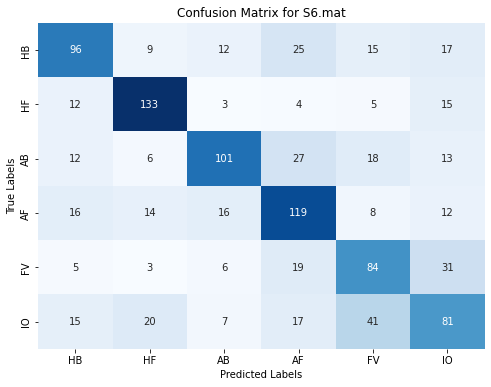

Training for subject S7.mat
Epoch 1/100


2024-09-13 14:43:32.133073: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


519/519 [==============================] - 11s 18ms/step - loss: 1.6439 - sparse_categorical_accuracy: 0.3928 - val_loss: 1.3978 - val_sparse_categorical_accuracy: 0.4609
Epoch 2/100
519/519 [==============================] - 9s 18ms/step - loss: 1.3371 - sparse_categorical_accuracy: 0.4837 - val_loss: 1.2739 - val_sparse_categorical_accuracy: 0.4928
Epoch 3/100
519/519 [==============================] - 9s 17ms/step - loss: 1.2406 - sparse_categorical_accuracy: 0.5165 - val_loss: 1.2594 - val_sparse_categorical_accuracy: 0.4986
Epoch 4/100
519/519 [==============================] - 9s 17ms/step - loss: 1.1696 - sparse_categorical_accuracy: 0.5459 - val_loss: 1.2064 - val_sparse_categorical_accuracy: 0.5236
Epoch 5/100
519/519 [==============================] - 9s 18ms/step - loss: 1.1313 - sparse_categorical_accuracy: 0.5604 - val_loss: 1.2346 - val_sparse_categorical_accuracy: 0.5159
Epoch 6/100
519/519 [==============================] - 9s 17ms/step - loss: 1.0854 - sparse_categoric

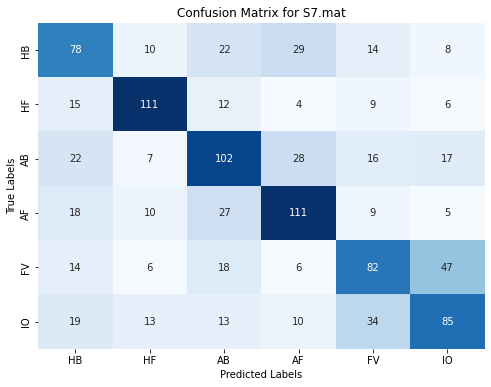

Training for subject S8.mat
Epoch 1/100


2024-09-13 14:47:50.193521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


519/519 [==============================] - 11s 18ms/step - loss: 1.8475 - sparse_categorical_accuracy: 0.2997 - val_loss: 1.6408 - val_sparse_categorical_accuracy: 0.3510
Epoch 2/100
519/519 [==============================] - 9s 17ms/step - loss: 1.6139 - sparse_categorical_accuracy: 0.3528 - val_loss: 1.6073 - val_sparse_categorical_accuracy: 0.3626
Epoch 3/100
519/519 [==============================] - 9s 17ms/step - loss: 1.5460 - sparse_categorical_accuracy: 0.3858 - val_loss: 1.5877 - val_sparse_categorical_accuracy: 0.3539
Epoch 4/100
519/519 [==============================] - 9s 17ms/step - loss: 1.4944 - sparse_categorical_accuracy: 0.4109 - val_loss: 1.5596 - val_sparse_categorical_accuracy: 0.3770
Epoch 5/100
519/519 [==============================] - 9s 17ms/step - loss: 1.4541 - sparse_categorical_accuracy: 0.4278 - val_loss: 1.5772 - val_sparse_categorical_accuracy: 0.3616
Epoch 6/100
519/519 [==============================] - 9s 17ms/step - loss: 1.4226 - sparse_categoric

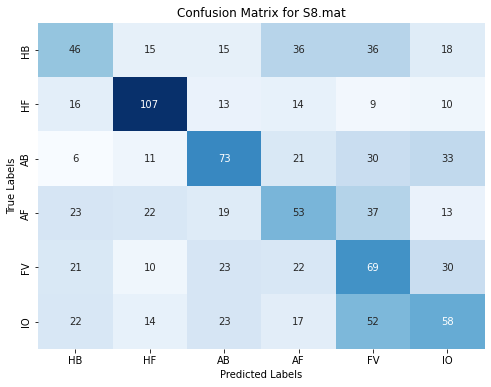

Training for subject S9.mat
Epoch 1/100


2024-09-13 14:52:41.262985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


519/519 [==============================] - 10s 18ms/step - loss: 1.7075 - sparse_categorical_accuracy: 0.3562 - val_loss: 1.9691 - val_sparse_categorical_accuracy: 0.2613
Epoch 2/100
519/519 [==============================] - 9s 17ms/step - loss: 1.4635 - sparse_categorical_accuracy: 0.4239 - val_loss: 1.5336 - val_sparse_categorical_accuracy: 0.4031
Epoch 3/100
519/519 [==============================] - 9s 18ms/step - loss: 1.3957 - sparse_categorical_accuracy: 0.4548 - val_loss: 1.6379 - val_sparse_categorical_accuracy: 0.3578
Epoch 4/100
519/519 [==============================] - 9s 17ms/step - loss: 1.3451 - sparse_categorical_accuracy: 0.4758 - val_loss: 1.5398 - val_sparse_categorical_accuracy: 0.4156
Epoch 5/100
519/519 [==============================] - 9s 17ms/step - loss: 1.2706 - sparse_categorical_accuracy: 0.5100 - val_loss: 1.6956 - val_sparse_categorical_accuracy: 0.3500
Epoch 6/100
519/519 [==============================] - 9s 18ms/step - loss: 1.2559 - sparse_categoric

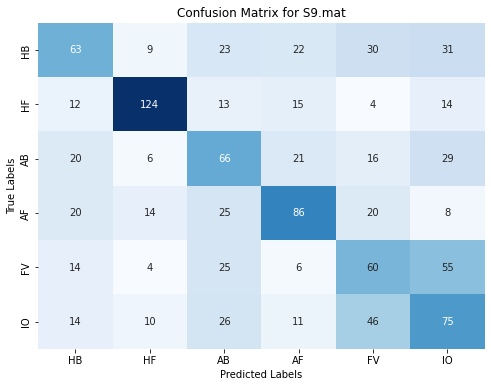

Training for subject S10.mat
Epoch 1/100


2024-09-13 14:58:28.828891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


519/519 [==============================] - 10s 18ms/step - loss: 1.6628 - sparse_categorical_accuracy: 0.3865 - val_loss: 1.3331 - val_sparse_categorical_accuracy: 0.4696
Epoch 2/100
519/519 [==============================] - 9s 17ms/step - loss: 1.3210 - sparse_categorical_accuracy: 0.4832 - val_loss: 1.2997 - val_sparse_categorical_accuracy: 0.5005
Epoch 3/100
519/519 [==============================] - 9s 17ms/step - loss: 1.2380 - sparse_categorical_accuracy: 0.5148 - val_loss: 1.2821 - val_sparse_categorical_accuracy: 0.5063
Epoch 4/100
519/519 [==============================] - 9s 17ms/step - loss: 1.1678 - sparse_categorical_accuracy: 0.5517 - val_loss: 1.2047 - val_sparse_categorical_accuracy: 0.5304
Epoch 5/100
519/519 [==============================] - 9s 18ms/step - loss: 1.1150 - sparse_categorical_accuracy: 0.5669 - val_loss: 1.2104 - val_sparse_categorical_accuracy: 0.5265
Epoch 6/100
519/519 [==============================] - 9s 17ms/step - loss: 1.0807 - sparse_categoric

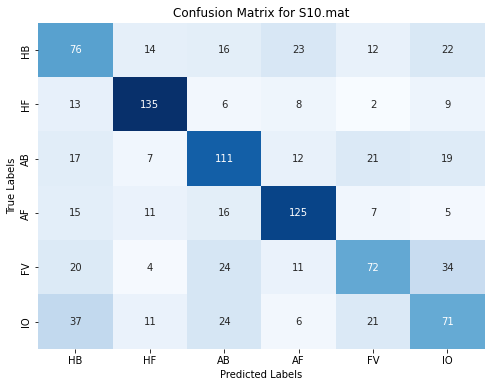

Average Accuracy: 0.5012
Average Precision: 0.5035
Average Recall: 0.5012
Average F1 Score: 0.4990


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.metrics import classification_report
file_names = ['S1.mat', 'S2.mat', 'S3.mat','S4.mat','S5.mat','S6.mat','S7.mat','S8.mat','S9.mat', 'S10.mat']

opt1 = tf.keras.optimizers.Adam(learning_rate=1e-4)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=20, restore_best_weights=True)

# Lists to store the results for each subject
confusion_matrices = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

for file_name in file_names:
    # Load the data for the current subject
    x_all_4_train, x_all_4_test, y_all_4_train, y_all_4_test = subject_data(file_name)
    
    # Compile and train the model
    print(f"Training for subject {file_name}")
    model.compile(optimizer=opt1, loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
    history = model.fit(x_all_4_train, y_all_4_train, batch_size=8, epochs=100, 
                        validation_data=(x_all_4_test, y_all_4_test), verbose=1, callbacks=[callback])
    
    # Make predictions on the test data
    y_pred_labels = np.argmax(model.predict(x_all_4_test), axis=-1)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_all_4_test, y_pred_labels)
    confusion_matrices.append(cm)
    
    # Calculate accuracy, precision, recall, and F1 score
    acc = accuracy_score(y_all_4_test, y_pred_labels)
    prec = precision_score(y_all_4_test, y_pred_labels, average='weighted')
    rec = recall_score(y_all_4_test, y_pred_labels, average='weighted')
    f1 = f1_score(y_all_4_test, y_pred_labels, average='weighted')
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

    print(classification_report(y_all_4_test, y_pred_labels))
    # Plot the heatmap for confusion matrix
    custom_labels = ['HB', 'HF', 'AB', 'AF', 'FV', 'IO']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=custom_labels, yticklabels=custom_labels)
    plt.title(f'Confusion Matrix for {file_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



# Calculate and print the average metrics
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1 = np.mean(f1_scores)

print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1 Score: {average_f1:.4f}")



